# Quality control of 10x transcriptomic FASTQ files
This Python Jupyter notebook performs quality control analysis on the FASTQ files created by [cellranger mkfastq](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/mkfastq).

Import Python modules:

In [1]:
import os

from IPython.display import HTML, display

import mizani

import pandas as pd

import plotnine as p9

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
expt = snakemake.wildcards.expt
qc_stats = snakemake.input.qc_stats
qc_plot = snakemake.output.qc_plot

print(f"Analyzing experiment {expt} using QC stats in these files:\n  " +
      '  \n'.join(qc_stats))

Analyzing experiment hashing_highMOI using QC stats in the following files:
  results/fastq10x/hashing_highMOI_2020-07-24_qc_stats.csv  
results/fastq10x/hashing_highMOI_2020-08-26_qc_stats.csv


Read the QC stats for each run for the experiment:

In [3]:
stats_df = pd.concat([pd.read_csv(statfile, names=['statistic', 'value'])
                      .assign(run10x=(os.path.basename(statfile)
                                      .replace('_qc_stats.csv', '')
                                      .replace(f"{expt}_", '')
                                      )
                              )
                      for statfile in qc_stats
                      ])

print(f"Statistics for {expt}")
display(HTML(
    stats_df
    .pivot_table(index='statistic', values='value', columns='run10x')
    .to_html()
    ))

Statistics for hashing_highMOI


run10x,2020-07-24,2020-08-26
statistic,,
barcode_exact_match_ratio,9.171790e-01,9.542469e-01
barcode_q30_base_ratio,9.593750e-01,9.888064e-01
bc_on_whitelist,9.708587e-01,9.687185e-01
gem_count_estimate,6.529000e+03,7.507300e+04
mean_barcode_qscore,3.481377e+01,3.851929e+01
number_reads,7.136665e+06,1.330668e+08
read1_q30_base_ratio,9.664714e-01,3.761572e-01
read2_q30_base_ratio,8.213481e-01,7.920858e-01


Plot the QC stats:

Saving plot to results/fastq10x/hashing_highMOI_qc_fastq10x.svg


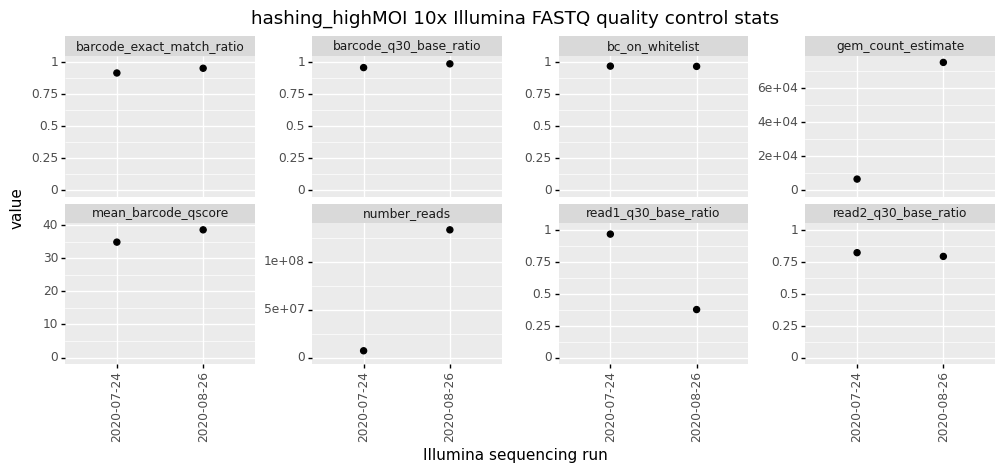

In [4]:
p = (p9.ggplot(stats_df, p9.aes('run10x', 'value')) +
     p9.geom_point(size=2) +
     p9.facet_wrap('~ statistic', ncol=4, scales='free_y') +
     p9.theme(axis_text_x=p9.element_text(angle=90),
              figure_size=(11 + 0.5 * stats_df['run10x'].nunique(), 4),
              subplots_adjust={'wspace': 0.3},) +
     p9.expand_limits(y=(0, 1)) +
     p9.scale_y_continuous(labels=mizani.formatters.custom_format('{:.2g}')) +
     p9.ggtitle(f"{expt} 10x Illumina FASTQ quality control stats") +
     p9.xlab('Illumina sequencing run')
     )
_ = p.draw()

print(f"Saving plot to {qc_plot}")
p.save(qc_plot, verbose=False)